In [100]:
import pandas as pd
import numpy as np
import os   
import matplotlib.pyplot as plt
import cv2 as cv2
import skimage
import copy

In [48]:
def findBbox(img, bbox):
    boxes = bbox[bbox['Name'] == img]
    boxes = boxes[['xmin', 'ymin', 'xmax', 'ymax']]
    return boxes

In [49]:
bbox = pd.read_csv('csv/bbox.csv')

In [90]:
def drawBox(img, boxes):
    path = os.path.join('sampledata\\images\\train', img)
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img1 = copy.deepcopy(img)
    for i in boxes.index:
        startpoint = (boxes['xmin'][i], boxes['ymin'][i])
        endpoint = (boxes['xmax'][i], boxes['ymax'][i])
        cv2.rectangle(img1, startpoint, endpoint, (255, 0, 0), 2)
    return img1

(407, 612, 3)


(-0.5, 611.5, 406.5, -0.5)

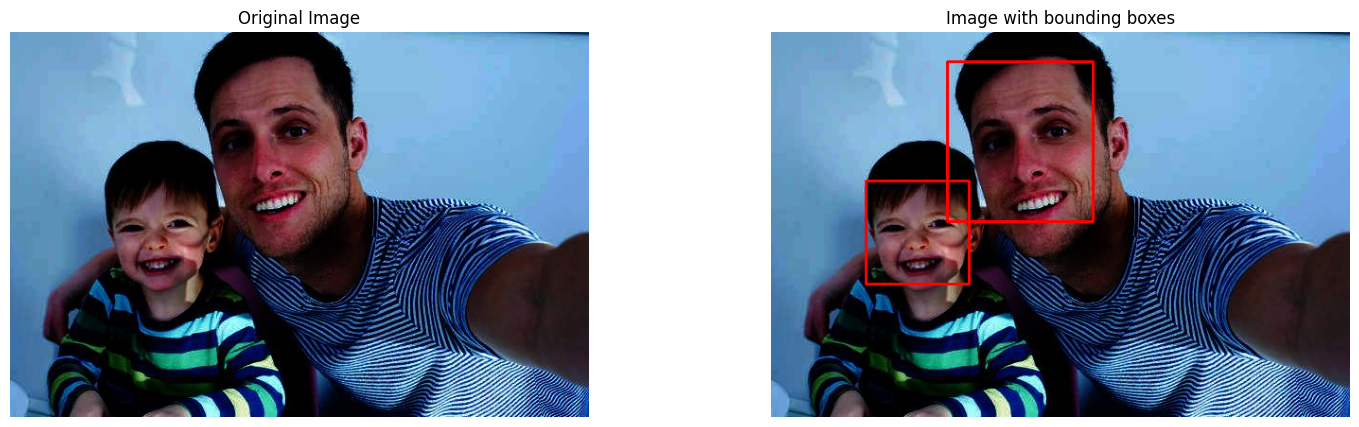

In [118]:
num = 9936
img = cv2.imread(f'K:\\ML\\Projects\\vista\\sampledata\\images\\train\\{num}.jpg')
print(img.shape)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
boxes = findBbox(f'{num}.jpg', bbox)
img_boxes = drawBox(f'{num}.jpg', boxes)
plt.figure(figsize=(18, 5))

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")
    
plt.subplot(1, 2, 2)
plt.imshow(img_boxes)
plt.title("Image with bounding boxes")
plt.axis("off")

### Preapreing data for YOLO custom model

In [52]:
def create_labels(flag = False):
    if flag:
        data = pd.read_csv("csv\\bbox.csv")
        labels_dir = "yolotrain\\labels" 
        os.makedirs(labels_dir, exist_ok=True) 
        for index, row in data.iterrows():
            image_name = row["Name"]
            image_name = image_name[:-4]
            image_path = f"yolotrain\\images\\train\\{image_name}.jpg" 
            # print(image_path)
            img = cv2.imread(image_path)
            # plt.imshow(img)
            height, width, channels = img.shape

            class_id = 0  
            xmin = row["xmin"] / width
            ymin = row["ymin"] / height
            xmax = row["xmax"] / width
            ymax = row["ymax"] / height
            x_center = (xmin + xmax) / 2
            y_center = (ymin + ymax) / 2
            width = xmax - xmin
            height = ymax - ymin

            txt_file_path = f"{labels_dir}/{image_name}.txt"  
            with open(txt_file_path, "a") as txt_file:
                txt_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

In [53]:
create_labels()

### Chaning exposures

In [93]:
def perform_histogram_equalization_cv2(image):
    #  Split the image into its individual channels
    b, g, r = cv2.split(image)

    # Perform histogram equalization on the grayscale image
    equalized_imgb = cv2.equalizeHist(b)
    equalized_imgg = cv2.equalizeHist(g)
    equalized_imgr   = cv2.equalizeHist(r)
    equalized_img = cv2.merge((equalized_imgb, equalized_imgg, equalized_imgr))
    plt.imshow(equalized_img)
    return equalized_img

In [55]:
def perform_histogram_equalization_adap(image):
    #  Split the image into its individual channels
    b, g, r = cv2.split(image)
    print(r.shape)
    clahe = cv2.createCLAHE()

    # Perform histogram equalization on the grayscale image
    equalized_imgb = clahe.apply(b)
    equalized_imgg = clahe.apply(g)
    equalized_imgr = clahe.apply(r)
    equalized_img = cv2.merge((equalized_imgb, equalized_imgg, equalized_imgr))
    return equalized_img

In [56]:
def perform_exposure_equalization_sklearn(image):
    #  Split the image into its individual channels
    b, g, r = cv2.split(image)
    clahe = cv2.createCLAHE()

    # Perform histogram equalization on the grayscale image
    equalized_imgb = clahe.apply(b)
    equalized_imgg = clahe.apply(g)
    equalized_imgr = clahe.apply(r)
    equalized_img = cv2.merge((equalized_imgb, equalized_imgg, equalized_imgr))
    return equalized_img

In [57]:
def perform_gamma_correction_sklearn(image, gamma = 2):
    gamma_img = skimage.exposure.adjust_gamma(image, gamma)
    return gamma_img

In [58]:
def perform_gamma_correction_cv2(image, gamma=1.0): 
  invGamma = 1.0 / gamma
  table = np.array([((i / 255.0) ** invGamma) * 255 for i in np.arange(0, 256)]).astype("uint8")
  return cv2.LUT(image, table) 

In [59]:
def change_brightness_contrast(image, alpha = 1.0, beta = 0):
    new_image = cv2.convertScaleAbs(image, alpha=alpha, beta=beta)
    return new_image

In [60]:
def increase_brightness(img, value = 50):
  if len(img.shape) == 3:  # Check for color image (BGR)
    brighter_image = img.copy()
    brighter_image[:,:,0] += value  # Increase Blue channel
    brighter_image[:,:,1] += value  # Increase Green channel
    brighter_image[:,:,2] += value  # Increase Red channel
  else:
    brighter_image = img + value  # Grayscale image
  brighter_image = np.clip(brighter_image, 0, 255)

  return brighter_image

(720, 1080)


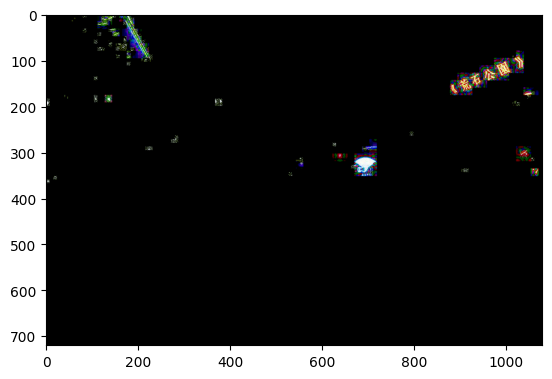

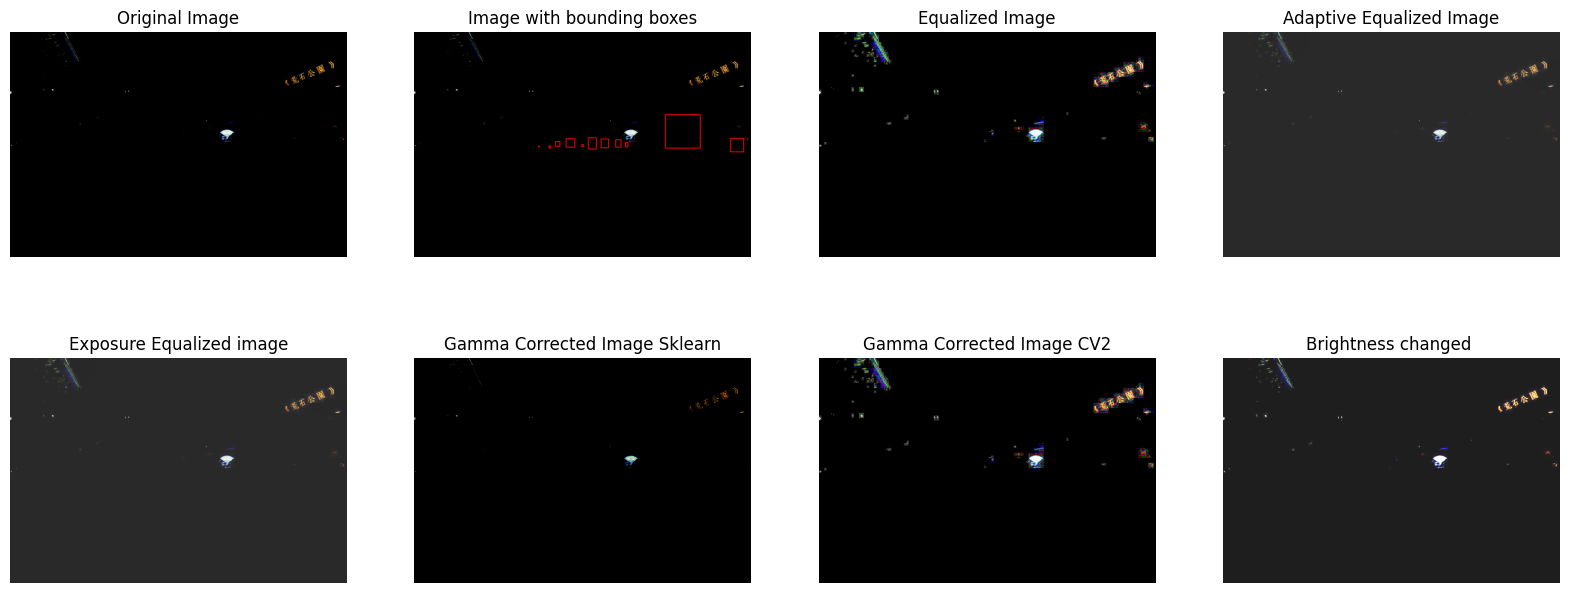

In [97]:
num = 1
img = cv2.imread(f'K:\\ML\\Projects\\vista\\sampledata\\images\\train\\{num}.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
boxes = findBbox(f'{num}.jpg', bbox)
img_boxes = drawBox(f'{num}.jpg', boxes)

equalized_img = perform_histogram_equalization_cv2(img)
equalized_img_adap = perform_histogram_equalization_adap(img)
equalized_img_exp = perform_exposure_equalization_sklearn(img)
gamma_corrected_img_sklearn = perform_gamma_correction_sklearn(img, 3)
gamma_corrected_img_cv2_def = perform_gamma_correction_cv2(img, 5)
brightness_changed = change_brightness_contrast(img, 3.5, 30)
gemini_img = increase_brightness(img, 30)

plt.figure(figsize=(20, 12))

plt.subplot(3, 4, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(3, 4, 2)
plt.imshow(img_boxes)
plt.title("Image with bounding boxes")
plt.axis("off")

plt.subplot(3, 4, 3)
plt.imshow(equalized_img)
plt.title("Equalized Image")
plt.axis("off")

plt.subplot(3, 4, 4)
plt.imshow(equalized_img_adap)
plt.title("Adaptive Equalized Image")
plt.axis("off")

plt.subplot(3, 4, 5)
plt.imshow(equalized_img_exp)
plt.title("Exposure Equalized image")
plt.axis("off")

plt.subplot(3, 4, 6)
plt.imshow(gamma_corrected_img_sklearn)
plt.title("Gamma Corrected Image Sklearn")
plt.axis("off")

plt.subplot(3, 4, 7)
plt.imshow(gamma_corrected_img_cv2_def)
plt.title("Gamma Corrected Image CV2")
plt.axis("off")

plt.subplot(3, 4, 8)
plt.imshow(brightness_changed)
plt.title("Brightness changed ")
plt.axis("off")


plt.show()

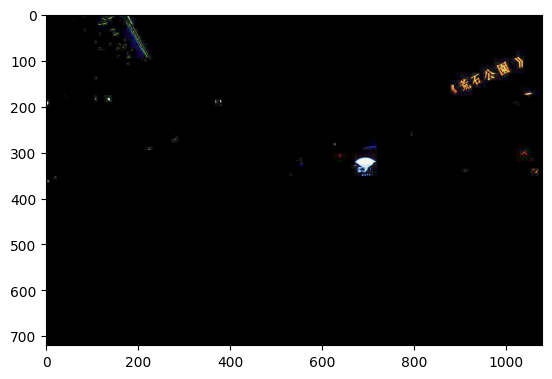

In [99]:
from skimage import io, exposure
gamma = 4.0 
image_dir = "K:\\ML\\Projects\\vista\\sampledata\\images\\train"
save_dir = "K:\\ML\\Projects\\vista\\yolotrain\\images\\train"
for filename in os.listdir(image_dir):
    if filename.endswith(".jpg"):
        image_path = os.path.join(image_dir, filename)
        image = io.imread(image_path)
        save_path = os.path.join(save_dir, filename)
        newimg = skimage.exposure.adjust_gamma(image, 0.45)
        plt.imshow(newimg)
        # cv2.imwrite(f"{save_path}", newimg)
        break